In [20]:
from datetime import datetime
from datetime import timedelta

from pymongo import MongoClient
from pandas import DataFrame
import pandas as pd

import tushare as ts
from WindPy import w
w.start();


import fdm

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


In [4]:

pro = ts.pro_api()

In [5]:
client = MongoClient("192.168.56.1",27017)

In [9]:
tushare = fdm.Tushare(client)
db = tushare.daily_basic()

In [10]:
clean = fdm.CleanData(client)
cdb = clean.pricing()

In [8]:
tdb = fdm.TempDB(client)
actp = tdb['actPrice']

In [14]:
codes = cdb.stock_codes()

In [29]:
MSCI_CN = {'CNY': '302400L.MI',
           'USD': '302400.MI'}
data = w.wsd("302400L.MI", "close", "1999-12-20", "2019-08-26", "",usedf=True)[1]
data.sort_index(inplace = True)
data.to_json('msci_china.bz2')

In [33]:
data = pd.read_json('msci_china.bz2').sort_index()


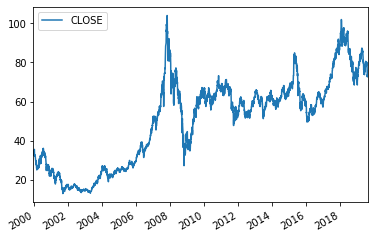

In [36]:
data.plot()

In [102]:
['CSI','SSE','SZSE','SW']
indexes = pro.index_basic(market='SW')
indexes.head()

,ts_code,name,market,publisher,category,base_date,base_point,list_date
0,801001.SI,申万50,SW,申万研究,其他,19991230,1000.0,None
1,801002.SI,申万中小板,SW,申万研究,其他,20040705,1000.0,None
2,801003.SI,申万A股,SW,申万研究,其他,19991230,1000.0,None
3,801004.SI,申万股改指数,SW,申万研究,其他,20050815,1000.0,None
4,801005.SI,申万创业板,SW,申万研究,其他,20091105,1000.0,20091106
